<a href="https://colab.research.google.com/github/wangechi01-a/Urban-Air-Pollution/blob/main/Urban_Air_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
!pip install optuna

# Import the necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from scipy.stats import boxcox

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold,GroupKFold,TimeSeriesSplit, StratifiedKFold


from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Urban air pollution/Train (4).csv')
test = pd.read_csv('/content/drive/MyDrive/Urban air pollution/Test (4).csv')
ss = pd.read_csv('/content/drive/MyDrive/Urban air pollution/SampleSubmission (4).csv')

In [4]:
#View the first few rows of the train dataset
train.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Check the first few rows of the test dataset
test.head()

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.600000,30.200001,0.00409,14.656824,3.956377,0.712605,0.000053,...,1.445658,-95.984984,22.942019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0OS9LVX X 2020-01-03,2020-01-03,0OS9LVX,18.300001,42.900002,0.00595,15.026544,4.230430,0.661892,0.000050,...,34.641758,-95.014908,18.539116,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0OS9LVX X 2020-01-04,2020-01-04,0OS9LVX,17.600000,41.299999,0.00590,15.511041,5.245728,1.640559,0.000050,...,55.872276,-94.015418,14.140820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0OS9LVX X 2020-01-05,2020-01-05,0OS9LVX,15.011948,53.100002,0.00709,14.441858,5.454001,-0.190532,0.000055,...,59.174188,-97.247602,32.730553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0OS9LVX X 2020-01-06,2020-01-06,0OS9LVX,9.700000,71.599998,0.00808,11.896295,3.511787,-0.279441,0.000055,...,40.925873,-96.057265,28.320527,1831.261597,3229.118652,0.031068,-100.278343,41.84708,-95.910744,28.498789


In [6]:
#Check the shape of the train,test dataset
train.shape, test.shape

((30557, 82), (16136, 77))

In [7]:
#Check for the info of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [8]:
#Check for more information on the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16136 entries, 0 to 16135
Data columns (total 77 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      16136 non-null  object 
 1   Date                                                 16136 non-null  object 
 2   Place_ID                                             16136 non-null  object 
 3   precipitable_water_entire_atmosphere                 16136 non-null  float64
 4   relative_humidity_2m_above_ground                    16136 non-null  float64
 5   specific_humidity_2m_above_ground                    16136 non-null  float64
 6   temperature_2m_above_ground                          16136 non-null  float64
 7   u_component_of_wind_10m_above_ground                 16136 non-null  float64
 8   v_component_of_wind_10m_above_ground                 16136 non-nul

In [9]:
#Check for missing values on the train dataset
train.isnull().sum() * 100 / len(train)

Place_ID X Date                  0.00000
Date                             0.00000
Place_ID                         0.00000
target                           0.00000
target_min                       0.00000
                                  ...   
L3_CH4_aerosol_optical_depth    81.04526
L3_CH4_sensor_azimuth_angle     81.04526
L3_CH4_sensor_zenith_angle      81.04526
L3_CH4_solar_azimuth_angle      81.04526
L3_CH4_solar_zenith_angle       81.04526
Length: 82, dtype: float64

Quite a number of columns in the train has missing values, we are going to drop columns with more than 70% missing values

In [10]:
#Check for missing values in the test data
test.isnull().sum() * 100 / len(test)

Place_ID X Date                          0.00000
Date                                     0.00000
Place_ID                                 0.00000
precipitable_water_entire_atmosphere     0.00000
relative_humidity_2m_above_ground        0.00000
                                          ...   
L3_CH4_aerosol_optical_depth            80.69534
L3_CH4_sensor_azimuth_angle             80.69534
L3_CH4_sensor_zenith_angle              80.69534
L3_CH4_solar_azimuth_angle              80.69534
L3_CH4_solar_zenith_angle               80.69534
Length: 77, dtype: float64

Quite a number of columns have missing values and we are going to drop columns with mpre than 70% missing values

In [11]:
# Create a function to remove NaNs with backward fill
def remove_nans(train, thresh):
    def nans_rate(train, col):
        return train[col].isna().sum() / train.shape[0]
    for col in train.columns:
        if nans_rate(train, col) >= thresh:
            train.drop(col, axis=1, inplace=True)
        else:
            train[col].fillna(method='bfill', inplace=True)
    return train

# Apply NaN handling
train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)
train.shape, test.shape

((30557, 75), (16136, 70))

In [12]:
# Loop through the columns and drop those that contain 'angle' in the train
columns_to_drop = [col for col in train.columns if 'angle' in col]

for col in columns_to_drop:
    train = train.drop(columns=[col])
# Loop through the columns and drop those that contain 'angle' in the test
columns_to_drop = [col for col in test.columns if 'angle' in col]

for col in columns_to_drop:
    test = test.drop(columns=[col])

In [13]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
cat_cols

['Place_ID X Date', 'Date', 'Place_ID']

In [14]:
train['Place_ID X Date'].head()

0    010Q650 X 2020-01-02
1    010Q650 X 2020-01-03
2    010Q650 X 2020-01-04
3    010Q650 X 2020-01-05
4    010Q650 X 2020-01-06
Name: Place_ID X Date, dtype: object

In [15]:
num_cols = [col for col in train.columns if train[col].dtype != 'object']
num_cols

['target',
 'target_min',
 'target_max',
 'target_variance',
 'target_count',
 'precipitable_water_entire_atmosphere',
 'relative_humidity_2m_above_ground',
 'specific_humidity_2m_above_ground',
 'temperature_2m_above_ground',
 'u_component_of_wind_10m_above_ground',
 'v_component_of_wind_10m_above_ground',
 'L3_NO2_NO2_column_number_density',
 'L3_NO2_NO2_slant_column_number_density',
 'L3_NO2_absorbing_aerosol_index',
 'L3_NO2_cloud_fraction',
 'L3_NO2_sensor_altitude',
 'L3_NO2_stratospheric_NO2_column_number_density',
 'L3_NO2_tropopause_pressure',
 'L3_NO2_tropospheric_NO2_column_number_density',
 'L3_O3_O3_column_number_density',
 'L3_O3_O3_effective_temperature',
 'L3_O3_cloud_fraction',
 'L3_CO_CO_column_number_density',
 'L3_CO_H2O_column_number_density',
 'L3_CO_cloud_height',
 'L3_CO_sensor_altitude',
 'L3_HCHO_HCHO_slant_column_number_density',
 'L3_HCHO_cloud_fraction',
 'L3_HCHO_tropospheric_HCHO_column_number_density',
 'L3_HCHO_tropospheric_HCHO_column_number_density_am

In [16]:
train = train.sort_values(by=['Date']).reset_index(drop=True)
test = test.sort_values(by=['Date']).reset_index(drop=True)
train.Date.max(),train.Date.min(), test.Date.max(),test.Date.min()

('2020-04-04', '2020-01-02', '2020-04-04', '2020-01-02')

In [17]:
train['Date'].head()

0    2020-01-02
1    2020-01-02
2    2020-01-02
3    2020-01-02
4    2020-01-02
Name: Date, dtype: object

In [18]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,30557.0,61.148045,46.861309,1.000000,25.000000,50.000000,80.000000,8.150000e+02
target_min,30557.0,29.025866,33.119775,1.000000,5.000000,15.000000,44.000000,4.380000e+02
target_max,30557.0,117.992234,100.417713,1.000000,60.000000,91.000000,155.000000,9.990000e+02
target_variance,30557.0,7983.756300,48630.902037,0.000000,1064.920000,2395.350000,5882.550000,1.841490e+06
target_count,30557.0,125.831135,146.581856,2.000000,44.000000,72.000000,150.000000,1.552000e+03
precipitable_water_entire_atmosphere,30557.0,15.302326,10.688573,0.420044,7.666667,12.200000,19.900000,7.260000e+01
relative_humidity_2m_above_ground,30557.0,70.552747,18.807884,5.128572,58.600002,74.099998,85.450001,1.000000e+02
specific_humidity_2m_above_ground,30557.0,0.006004,0.003787,0.000139,0.003403,0.004912,0.007562,2.161499e-02
temperature_2m_above_ground,30557.0,9.321342,9.343226,-34.647879,3.123071,8.478424,16.201563,3.743792e+01
u_component_of_wind_10m_above_ground,30557.0,0.416886,2.707990,-15.559646,-1.097864,0.222092,1.772925,1.795512e+01


# Visualization

In [19]:
train['target'].describe()

count    30557.000000
mean        61.148045
std         46.861309
min          1.000000
25%         25.000000
50%         50.000000
75%         80.000000
max        815.000000
Name: target, dtype: float64

<Axes: xlabel='target', ylabel='Density'>

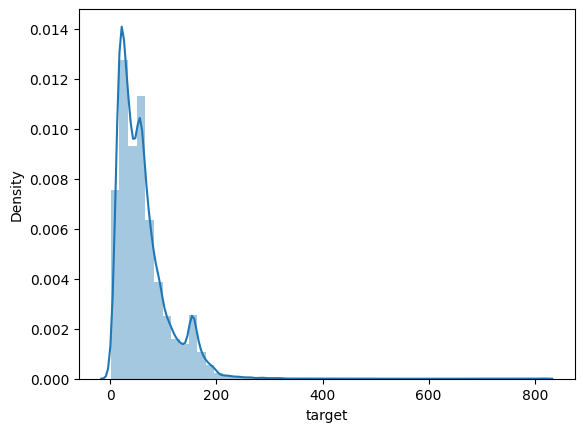

In [20]:
sns.distplot(train['target'])

<Axes: xlabel='target', ylabel='Density'>

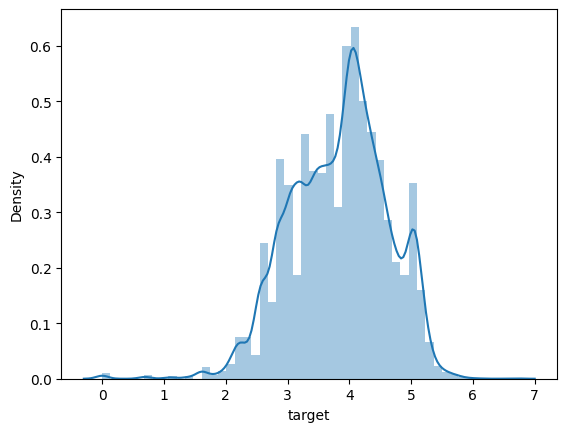

In [21]:
sns.distplot(np.log(train['target']))

# Data Processing

In [22]:
train.drop(['Place_ID X Date','Place_ID','target_min','target_max','target_variance','target_count'], axis=1, inplace=True)

Getting the Date features

In [23]:
for df in [train, test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['week'] = df['Date'].dt.isocalendar().week
    df.drop(columns=['Date'], inplace=True)


In [24]:
train.head()

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,...,L3_AER_AI_sensor_altitude,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,year,month,day,week
0,38.0,11.000000,60.200001,0.008040,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,...,840209.874619,-0.000127,0.312521,-0.000040,-1.861476,0.000000,2020,1,2,1
1,210.0,7.600000,92.900002,0.003340,-0.923163,1.186377,0.442605,0.000080,0.000208,-1.407829,...,832891.668863,0.001213,0.125776,0.000150,-2.049941,0.245479,2020,1,2,1
2,69.0,30.350000,97.450001,0.014210,18.806818,-0.948623,-0.937395,0.000046,0.000085,-1.912551,...,828958.592599,0.000027,0.715339,0.000018,-2.568235,0.293534,2020,1,2,1
3,33.0,24.733333,49.883334,0.008353,19.320164,0.799710,3.212605,0.000058,0.000121,-0.649328,...,829109.456091,0.000111,0.383799,0.000043,-1.541329,0.006099,2020,1,2,1
4,57.0,27.760000,52.140000,0.008930,22.560834,-1.481623,-1.181395,0.000073,0.000168,0.955031,...,844493.897695,0.000377,0.513152,0.000172,0.876192,0.175392,2020,1,2,1


# Positive Correlation

In [25]:
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() > 0]

day                                                0.005238
L3_CO_H2O_column_number_density                    0.006158
L3_SO2_SO2_column_number_density_amf               0.012934
L3_CO_sensor_altitude                              0.014558
L3_NO2_absorbing_aerosol_index                     0.038610
L3_SO2_SO2_column_number_density                   0.039267
L3_O3_O3_effective_temperature                     0.042240
L3_NO2_stratospheric_NO2_column_number_density     0.048893
L3_NO2_sensor_altitude                             0.051391
L3_SO2_SO2_slant_column_number_density             0.056194
L3_AER_AI_absorbing_aerosol_index                  0.069878
L3_CLOUD_cloud_base_pressure                       0.098931
L3_CLOUD_cloud_top_pressure                        0.123883
L3_SO2_absorbing_aerosol_index                     0.130994
L3_NO2_tropospheric_NO2_column_number_density      0.293231
L3_HCHO_HCHO_slant_column_number_density           0.305655
L3_NO2_NO2_column_number_density        

# Negative Correlation

In [26]:
train.corr()['target'].sort_values()[train.corr()['target'].sort_values() < 0]

L3_AER_AI_sensor_altitude                             -0.307717
u_component_of_wind_10m_above_ground                  -0.148202
month                                                 -0.122800
week                                                  -0.121427
L3_CLOUD_cloud_optical_depth                          -0.118600
L3_NO2_cloud_fraction                                 -0.118165
L3_CLOUD_cloud_fraction                               -0.113949
L3_O3_cloud_fraction                                  -0.107418
L3_CLOUD_cloud_top_height                             -0.107207
L3_NO2_tropopause_pressure                            -0.096293
L3_HCHO_tropospheric_HCHO_column_number_density_amf   -0.094813
L3_CLOUD_cloud_base_height                            -0.089486
relative_humidity_2m_above_ground                     -0.084835
L3_CO_cloud_height                                    -0.082476
L3_O3_O3_column_number_density                        -0.081184
L3_CLOUD_surface_albedo                 

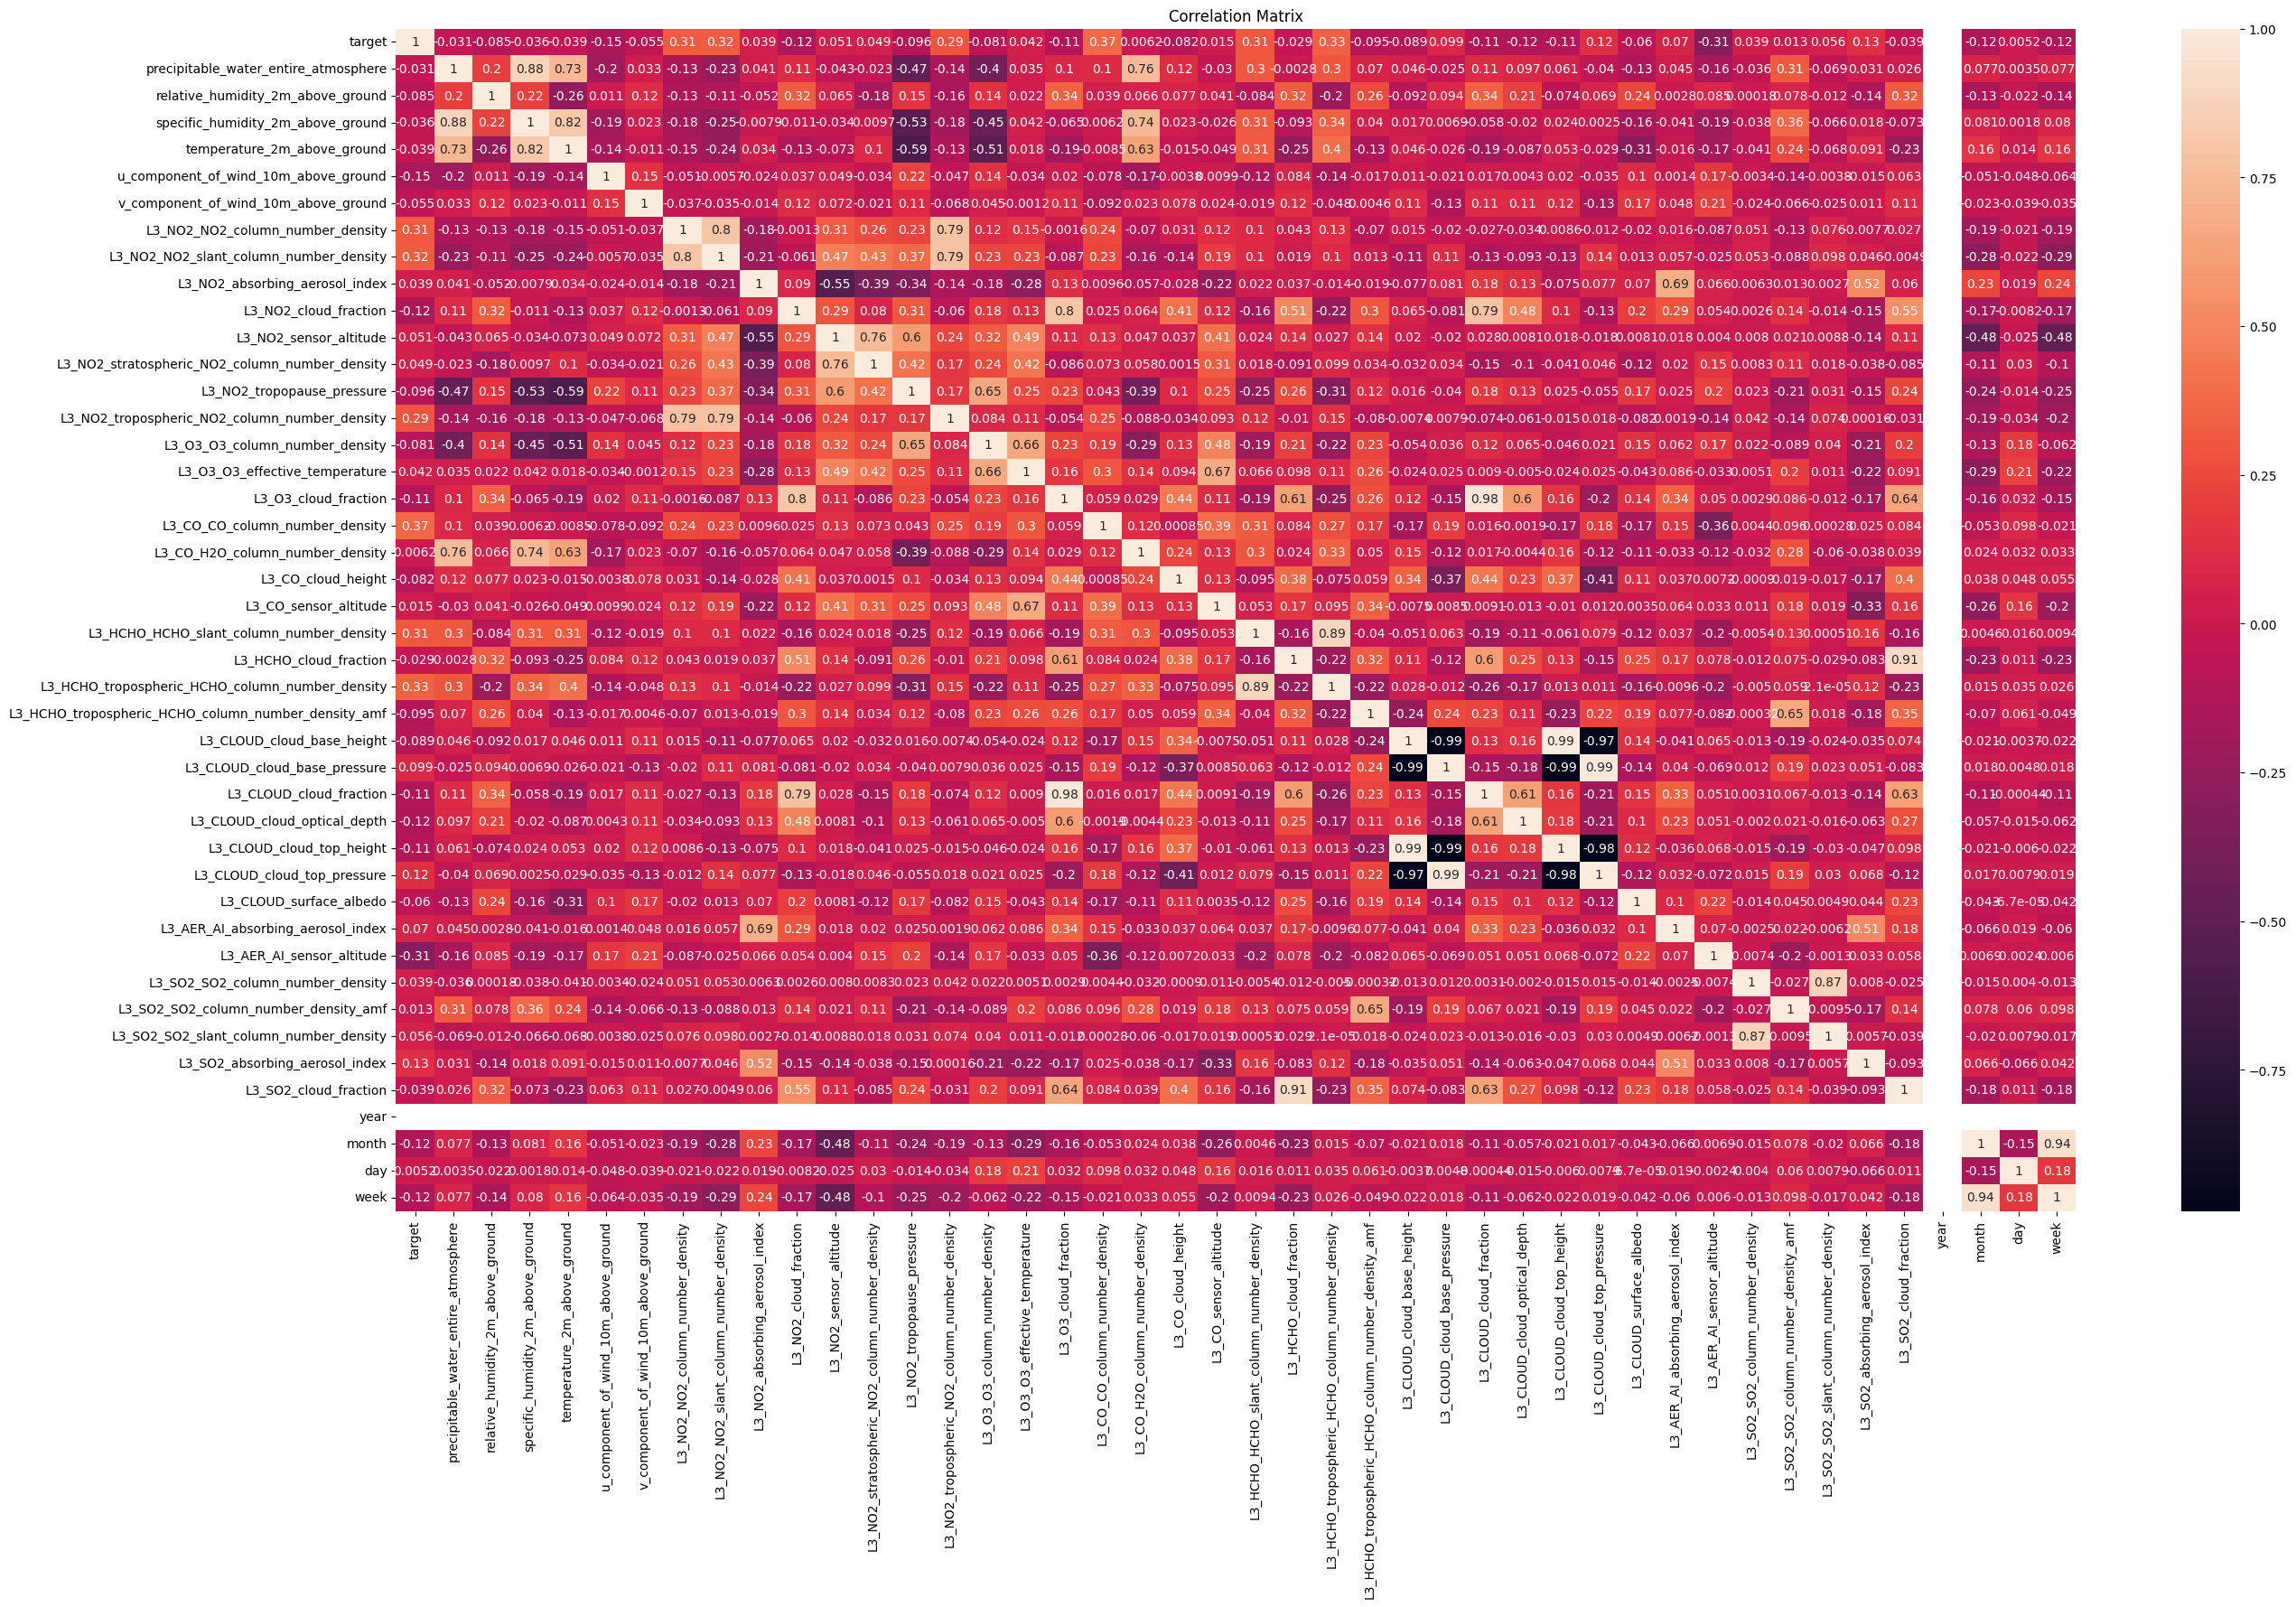

In [27]:
corr_matrix = train.corr()
plt.figure(figsize= (30,17))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [28]:
train.columns

Index(['target', 'precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_CO_CO_column_number_density',
       'L3_CO_H2O_column_number_density', 'L3_CO_cloud_height',
       'L3_CO_sensor_altitude', 'L3_HCHO_HCHO_slant_column_number_density',
       'L3_HCHO_cloud_fraction',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'L3_HCHO_tr

In [29]:
main_cols = [col for col in train.columns if col not in ['target']]
independent_features = train[main_cols]
dependent_features= train.target
test = test[main_cols]

X = independent_features
y = dependent_features
model = CatBoostRegressor(random_state = 42)

import random
random.seed(123)

train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.18,random_state = 47)
model.fit(train_features, train_y,eval_set = [(train_features, train_y),(valid_features,valid_y)], early_stopping_rounds = 500,
          verbose = 200)

Learning rate set to 0.084435
0:	learn: 45.9510756	test: 45.9510756	test1: 44.0743595	best: 44.0743595 (0)	total: 103ms	remaining: 1m 43s
200:	learn: 28.2239660	test: 28.2239660	test1: 28.5891537	best: 28.5891537 (200)	total: 6.81s	remaining: 27.1s
400:	learn: 24.8474111	test: 24.8474111	test1: 27.1181350	best: 27.1181350 (400)	total: 9.97s	remaining: 14.9s
600:	learn: 22.5448866	test: 22.5448866	test1: 26.3425521	best: 26.3425521 (600)	total: 13.1s	remaining: 8.73s
800:	learn: 20.7706395	test: 20.7706395	test1: 25.8411649	best: 25.8401710 (799)	total: 16.4s	remaining: 4.07s
999:	learn: 19.3583933	test: 19.3583933	test1: 25.4253954	best: 25.4253954 (999)	total: 22.2s	remaining: 0us

bestTest = 25.42539544
bestIteration = 999



In [30]:

pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_catt_varimp(model, train_columns, max_vars=350):

    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df

get_catt_varimp(model, X.columns)

,feature_name,varimp (%)
17,L3_CO_CO_column_number_density,12.052632
33,L3_AER_AI_sensor_altitude,7.313897
7,L3_NO2_NO2_slant_column_number_density,6.217155
3,temperature_2m_above_ground,5.867785
23,L3_HCHO_tropospheric_HCHO_column_number_density,5.421825
5,v_component_of_wind_10m_above_ground,4.349163
20,L3_CO_sensor_altitude,4.162217
31,L3_CLOUD_surface_albedo,3.82487
4,u_component_of_wind_10m_above_ground,3.809003
24,L3_HCHO_tropospheric_HCHO_column_number_densit...,3.424113


In [31]:
# Call the function and assign the result to cv_varimp_df
cv_varimp_df = get_catt_varimp(model, X.columns)

non_zero_features = cv_varimp_df[cv_varimp_df['varimp (%)']> 0]['feature_name'].values # Use 'varimp (%)' as column name
non_zero_features

array(['L3_CO_CO_column_number_density', 'L3_AER_AI_sensor_altitude',
       'L3_NO2_NO2_slant_column_number_density',
       'temperature_2m_above_ground',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'v_component_of_wind_10m_above_ground', 'L3_CO_sensor_altitude',
       'L3_CLOUD_surface_albedo', 'u_component_of_wind_10m_above_ground',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_NO2_tropopause_pressure', 'L3_NO2_sensor_altitude',
       'relative_humidity_2m_above_ground', 'week',
       'L3_CLOUD_cloud_optical_depth',
       'precipitable_water_entire_atmosphere',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_effective_temperature',
       'specific_humidity_2m_above_ground',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_HCHO_HCHO_slant_column_number_density',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density',
       'L3_NO2_NO2_column_number_densit

In [32]:
corr = train_features[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = train_features[non_zero_features].columns[columns]
selected_columns

Index(['L3_CO_CO_column_number_density', 'L3_AER_AI_sensor_altitude',
       'L3_NO2_NO2_slant_column_number_density', 'temperature_2m_above_ground',
       'L3_HCHO_tropospheric_HCHO_column_number_density',
       'v_component_of_wind_10m_above_ground', 'L3_CO_sensor_altitude',
       'L3_CLOUD_surface_albedo', 'u_component_of_wind_10m_above_ground',
       'L3_HCHO_tropospheric_HCHO_column_number_density_amf',
       'L3_NO2_tropopause_pressure', 'L3_NO2_sensor_altitude',
       'relative_humidity_2m_above_ground', 'week',
       'L3_CLOUD_cloud_optical_depth', 'precipitable_water_entire_atmosphere',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_effective_temperature',
       'L3_SO2_SO2_column_number_density_amf',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_CO_H2O_column_number_density',
       'L3_HCHO_cloud_fraction', 'day', 'L3_SO2_absorbing_aerosol_index',
       'L3_NO2_absorbing_aerosol_index'

In [33]:
len(selected_columns)

33

In [34]:
# X contains your features and y contains your target variable
X = train[selected_columns].values
target = 'target'
y = train[target].values

# Here, we divide y into 10 bins based on its values to stratify by the target distribution
bins = np.linspace(y.min(), y.max(), 10)
y_bins = np.digitize(y, bins)

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'random_state': 42,
        'verbose': 0
    }

    rmse_folds = []
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y_bins):
        print("*" * 100)
        X_train, X_test = X[train_idx], X[val_idx]
        y_train, y_test = y[train_idx], y[val_idx]

        model = CatBoostRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

        preds = model.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_folds.append(rmse)

    return np.mean(rmse_folds)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

# Train and evaluate the model using the best parameters
oof_pred = []
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y_bins):
    print("*" * 100)
    X_train, X_test = X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]

    model = CatBoostRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print(f"RMSE for fold with best params: {rmse}")
    oof_pred.append(rmse)

    # Inference (assuming test_df contains your test data)
    test_preds = model.predict(test[selected_columns].values)
    # Store or use test_preds as needed

print(f"The average RMSE across the folds: {np.mean(oof_pred)}")


[I 2024-07-09 14:42:07,326] A new study created in memory with name: no-name-790f1225-ab97-4bbb-879b-7c2f2b268b2e


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:42:38,053] Trial 0 finished with value: 32.27110021532539 and parameters: {'iterations': 456, 'learning_rate': 0.01369306139639814, 'depth': 6, 'l2_leaf_reg': 0.032882699958765076}. Best is trial 0 with value: 32.27110021532539.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:49:15,629] Trial 1 finished with value: 28.63703412447465 and parameters: {'iterations': 814, 'learning_rate': 0.013556402435639164, 'depth': 10, 'l2_leaf_reg': 0.08764981420089298}. Best is trial 1 with value: 28.63703412447465.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:52:05,176] Trial 2 finished with value: 30.65520231924851 and parameters: {'iterations': 600, 'learning_rate': 0.011237129380522933, 'depth': 9, 'l2_leaf_reg': 5.834980090383479}. Best is trial 1 with value: 28.63703412447465.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:52:24,613] Trial 3 finished with value: 33.90869798024907 and parameters: {'iterations': 461, 'learning_rate': 0.012994459500069444, 'depth': 4, 'l2_leaf_reg': 0.0415931165043235}. Best is trial 1 with value: 28.63703412447465.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:55:07,649] Trial 4 finished with value: 29.169407631988584 and parameters: {'iterations': 334, 'learning_rate': 0.02719152378928852, 'depth': 10, 'l2_leaf_reg': 0.07747079329690555}. Best is trial 1 with value: 28.63703412447465.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:56:42,693] Trial 5 finished with value: 27.348923061507467 and parameters: {'iterations': 954, 'learning_rate': 0.049982236806541756, 'depth': 7, 'l2_leaf_reg': 0.9550651693811841}. Best is trial 5 with value: 27.348923061507467.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:57:07,627] Trial 6 finished with value: 31.58590818093757 and parameters: {'iterations': 348, 'learning_rate': 0.02437853741418872, 'depth': 6, 'l2_leaf_reg': 0.025289368254693443}. Best is trial 5 with value: 27.348923061507467.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 14:57:40,643] Trial 7 finished with value: 31.17336291939159 and parameters: {'iterations': 924, 'learning_rate': 0.023241395882029014, 'depth': 4, 'l2_leaf_reg': 0.02911380271439977}. Best is trial 5 with value: 27.348923061507467.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:03:55,043] Trial 8 finished with value: 29.01494925927931 and parameters: {'iterations': 766, 'learning_rate': 0.012267458761741538, 'depth': 10, 'l2_leaf_reg': 0.013267991756940002}. Best is trial 5 with value: 27.348923061507467.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:05:49,198] Trial 9 finished with value: 28.551062634156356 and parameters: {'iterations': 233, 'learning_rate': 0.05562186226821526, 'depth': 10, 'l2_leaf_reg': 0.15030310396770116}. Best is trial 5 with value: 27.348923061507467.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:08:28,813] Trial 10 finished with value: 26.35704817169881 and parameters: {'iterations': 993, 'learning_rate': 0.08123760550886744, 'depth': 8, 'l2_leaf_reg': 1.4025906563730262}. Best is trial 10 with value: 26.35704817169881.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:10:56,883] Trial 11 finished with value: 26.310475586697603 and parameters: {'iterations': 925, 'learning_rate': 0.08483112903586626, 'depth': 8, 'l2_leaf_reg': 1.1775875065506445}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:12:50,744] Trial 12 finished with value: 26.62188814855051 and parameters: {'iterations': 711, 'learning_rate': 0.08794361526999303, 'depth': 8, 'l2_leaf_reg': 1.4028094990917601}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:15:28,267] Trial 13 finished with value: 26.417734028069937 and parameters: {'iterations': 980, 'learning_rate': 0.09823873139815904, 'depth': 8, 'l2_leaf_reg': 0.0025857413505455773}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:17:43,414] Trial 14 finished with value: 26.541296839627606 and parameters: {'iterations': 848, 'learning_rate': 0.06926965591245174, 'depth': 8, 'l2_leaf_reg': 0.5014406839286953}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:18:50,545] Trial 15 finished with value: 28.725144798949408 and parameters: {'iterations': 678, 'learning_rate': 0.03981251422028093, 'depth': 7, 'l2_leaf_reg': 8.613090465116963}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:18:58,779] Trial 16 finished with value: 31.850584105278436 and parameters: {'iterations': 113, 'learning_rate': 0.07101445999583517, 'depth': 6, 'l2_leaf_reg': 2.9517097367168303}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:23:24,830] Trial 17 finished with value: 26.93195293764862 and parameters: {'iterations': 887, 'learning_rate': 0.03682570658292536, 'depth': 9, 'l2_leaf_reg': 0.28170591048942334}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:24:32,265] Trial 18 finished with value: 27.419922407800815 and parameters: {'iterations': 625, 'learning_rate': 0.07666931978227504, 'depth': 7, 'l2_leaf_reg': 2.3252010339355005}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:28:29,336] Trial 19 finished with value: 26.5336487849976 and parameters: {'iterations': 803, 'learning_rate': 0.056634050977472254, 'depth': 9, 'l2_leaf_reg': 0.6423521996704585}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:28:55,714] Trial 20 finished with value: 30.164506947563105 and parameters: {'iterations': 509, 'learning_rate': 0.046307021373862604, 'depth': 5, 'l2_leaf_reg': 0.2492024207678037}. Best is trial 11 with value: 26.310475586697603.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:31:43,429] Trial 21 finished with value: 26.273371192250725 and parameters: {'iterations': 1000, 'learning_rate': 0.09091734362621517, 'depth': 8, 'l2_leaf_reg': 0.0013958825820210546}. Best is trial 21 with value: 26.273371192250725.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:34:21,402] Trial 22 finished with value: 26.263536371509506 and parameters: {'iterations': 985, 'learning_rate': 0.09588248800690291, 'depth': 8, 'l2_leaf_reg': 0.0013816678170507559}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:38:34,148] Trial 23 finished with value: 26.313636225226986 and parameters: {'iterations': 890, 'learning_rate': 0.09548901679216562, 'depth': 9, 'l2_leaf_reg': 0.0015075288932931215}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:40:12,311] Trial 24 finished with value: 26.880372736124745 and parameters: {'iterations': 998, 'learning_rate': 0.0660779933647814, 'depth': 7, 'l2_leaf_reg': 0.003902540817673469}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:42:07,770] Trial 25 finished with value: 26.700051155577775 and parameters: {'iterations': 726, 'learning_rate': 0.09962818245868667, 'depth': 8, 'l2_leaf_reg': 0.007829962462007092}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:46:14,316] Trial 26 finished with value: 28.29254046006359 and parameters: {'iterations': 875, 'learning_rate': 0.017457107999767206, 'depth': 9, 'l2_leaf_reg': 0.0013779512372601396}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:47:44,099] Trial 27 finished with value: 26.96308404059191 and parameters: {'iterations': 932, 'learning_rate': 0.06352216948366605, 'depth': 7, 'l2_leaf_reg': 0.005340241134092193}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:49:48,780] Trial 28 finished with value: 26.555702913872118 and parameters: {'iterations': 782, 'learning_rate': 0.08042992042819187, 'depth': 8, 'l2_leaf_reg': 0.011954779545571196}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:50:43,456] Trial 29 finished with value: 27.870493224398228 and parameters: {'iterations': 842, 'learning_rate': 0.05685974860190468, 'depth': 6, 'l2_leaf_reg': 0.0010165189161764063}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:51:28,083] Trial 30 finished with value: 30.82169692689623 and parameters: {'iterations': 938, 'learning_rate': 0.017581506128608787, 'depth': 5, 'l2_leaf_reg': 0.00252966815584403}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 15:55:47,717] Trial 31 finished with value: 26.405040064435166 and parameters: {'iterations': 886, 'learning_rate': 0.08834056814363134, 'depth': 9, 'l2_leaf_reg': 0.0016564741637266022}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:00:52,421] Trial 32 finished with value: 26.28625555674945 and parameters: {'iterations': 935, 'learning_rate': 0.09575184316048277, 'depth': 9, 'l2_leaf_reg': 0.0025274089454804865}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:03:34,007] Trial 33 finished with value: 26.34234597589568 and parameters: {'iterations': 999, 'learning_rate': 0.07838141016807339, 'depth': 8, 'l2_leaf_reg': 0.004812925071477356}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:07:28,970] Trial 34 finished with value: 26.433214259807755 and parameters: {'iterations': 830, 'learning_rate': 0.08844937227037655, 'depth': 9, 'l2_leaf_reg': 0.002577668248972036}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:11:47,922] Trial 35 finished with value: 26.303067319238252 and parameters: {'iterations': 922, 'learning_rate': 0.0627742892048688, 'depth': 9, 'l2_leaf_reg': 0.010367847337576296}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:16:28,232] Trial 36 finished with value: 26.594824296922628 and parameters: {'iterations': 595, 'learning_rate': 0.06266610326146495, 'depth': 10, 'l2_leaf_reg': 0.009663826362759757}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:20:51,300] Trial 37 finished with value: 26.437295187291635 and parameters: {'iterations': 949, 'learning_rate': 0.04787752832396018, 'depth': 9, 'l2_leaf_reg': 0.003721399738496892}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:26:46,195] Trial 38 finished with value: 26.49262217400914 and parameters: {'iterations': 752, 'learning_rate': 0.07250784603963853, 'depth': 10, 'l2_leaf_reg': 0.015500936621631366}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:28:39,871] Trial 39 finished with value: 28.236355015377203 and parameters: {'iterations': 409, 'learning_rate': 0.040253701607162254, 'depth': 9, 'l2_leaf_reg': 0.05214727410142623}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:34:06,996] Trial 41 finished with value: 26.418054802483233 and parameters: {'iterations': 913, 'learning_rate': 0.08371450442395842, 'depth': 8, 'l2_leaf_reg': 0.006174198180046731}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:36:37,434] Trial 42 finished with value: 26.318429006488927 and parameters: {'iterations': 959, 'learning_rate': 0.09942542298118555, 'depth': 8, 'l2_leaf_reg': 0.0010885886913462916}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:38:48,843] Trial 43 finished with value: 26.526152373599118 and parameters: {'iterations': 844, 'learning_rate': 0.08958359397558945, 'depth': 8, 'l2_leaf_reg': 0.08445115222442381}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:41:11,190] Trial 44 finished with value: 26.465250473645693 and parameters: {'iterations': 910, 'learning_rate': 0.07580422525434256, 'depth': 8, 'l2_leaf_reg': 0.026374796281816888}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:42:43,537] Trial 45 finished with value: 27.00006470123052 and parameters: {'iterations': 949, 'learning_rate': 0.0605140780380002, 'depth': 7, 'l2_leaf_reg': 0.019080552945838238}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:49:04,983] Trial 46 finished with value: 26.372978495686873 and parameters: {'iterations': 808, 'learning_rate': 0.0691197199480721, 'depth': 10, 'l2_leaf_reg': 0.001987948745918306}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:51:37,014] Trial 47 finished with value: 26.283903175767236 and parameters: {'iterations': 968, 'learning_rate': 0.08926790141945584, 'depth': 8, 'l2_leaf_reg': 0.0034084887664928435}. Best is trial 22 with value: 26.263536371509506.


****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************


[I 2024-07-09 16:57:37,863] Trial 49 finished with value: 26.63566089808508 and parameters: {'iterations': 997, 'learning_rate': 0.09148922095393074, 'depth': 7, 'l2_leaf_reg': 0.00622317944853148}. Best is trial 22 with value: 26.263536371509506.


Best hyperparameters found by Optuna:
{'iterations': 985, 'learning_rate': 0.09588248800690291, 'depth': 8, 'l2_leaf_reg': 0.0013816678170507559}
****************************************************************************************************
0:	learn: 45.2124416	test: 45.6021562	best: 45.6021562 (0)	total: 43.3ms	remaining: 42.6s
1:	learn: 43.9032910	test: 44.3291587	best: 44.3291587 (1)	total: 75.5ms	remaining: 37.1s
2:	learn: 42.6241565	test: 43.0559221	best: 43.0559221 (2)	total: 106ms	remaining: 34.8s
3:	learn: 41.5451961	test: 42.0615400	best: 42.0615400 (3)	total: 140ms	remaining: 34.3s
4:	learn: 40.5786660	test: 41.1388213	best: 41.1388213 (4)	total: 177ms	remaining: 34.8s
5:	learn: 39.7004743	test: 40.2440613	best: 40.2440613 (5)	total: 210ms	remaining: 34.3s
6:	learn: 38.9881355	test: 39.5867395	best: 39.5867395 (6)	total: 241ms	remaining: 33.7s
7:	learn: 38.3366309	test: 38.9708911	best: 38.9708911 (7)	total: 283ms	remaining: 34.5s
8:	learn: 37.7585308	test: 38.4232113	b

In [39]:
submission = pd.DataFrame({
    "Place_ID X Date": ss["Place_ID X Date"],
    "target":test_preds
})
submission.to_csv('submission_urban.csv', index=False)
submission.head()

,Place_ID X Date,target
0,0OS9LVX X 2020-01-02,34.141251
1,0OS9LVX X 2020-01-03,171.728565
2,0OS9LVX X 2020-01-04,32.931413
3,0OS9LVX X 2020-01-05,88.509976
4,0OS9LVX X 2020-01-06,56.615694
